# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [4]:
import os
import glob
import sys
import tensorflow as tf
import time

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

# from tensorflow.contrib.keras.python.keras.callbacks import TensorBoard

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [5]:
# Simple layers (no dropout)
def separable_conv2d_batchnorm(input_layer, filters, strides=1, kernel_size=3):
    output_layer = SeparableConv2DKeras(filters=filters, kernel_size=kernel_size, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer)
    return output_layer


def conv2d_batchnorm(input_layer, filters, kernel_size=5, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer


# pooling layers
def max_pool(input_layer, pool_size=2, strides=2):
    output_layer = layers.MaxPool2D(pool_size = pool_size, strides=strides, padding='same')(input_layer)
    return output_layer

# n
def avg_pool(input_layer, pool_size=2, strides=2):
    output_layer = layers.AvgPool2D(padding='same', pool_size=pool_size, strides=strides)(input_layer)
    return output_layer


# Layers with dropout applied on inputs
def separable_conv2d_batchnorm_dropout(input_layer, filters, strides=1, kernel_size=3, rate=0.5):
    output_layer = layers.Dropout(rate = rate)(input_layer)
    output_layer = SeparableConv2DKeras(filters=filters, kernel_size=kernel_size, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer)
    return output_layer


def conv2d_batchnorm_dropout(input_layer, filters, kernel_size=3, strides=1, rate=0.5):
    output_layer = layers.Dropout(rate=rate)(input_layer)
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(output_layer)
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [6]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [ ]:
def stem_block(input_layer, filters=32, strides=1, kernel_size=3, secondary_dropout=0.5):
    # First layer is a simple separable_conv2d_batchnorm with no pooling or dropout
    interface = separable_conv2d_batchnorm(input_layer, filters, strides, kernel_size=kernel_size)
    # second layer is a separable_conv2d_batchnorm with dropout
    output_layer = separable_conv2d_batchnorm_dropout(interface, filters=filters, strides=strides, 
                                                      kernel_size=kernel_size, rate=secondary_dropout)
    return output_layer

def encoder_block(input_layer, filters, conv_strides, pool_size, pool_strides, kernel_size, rate):
    pooled_layer = max_pool(input_layer, pool_size, pool_strides)
    output_layer = separable_conv2d_batchnorm_dropout(pooled_layer, filters, conv_strides, 
                                                      kernel_size=kernel_size, rate=rate)
    return output_layer


def OG_encoder(input_layer, filters, strides, kernel_size=3):
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides, kernel_size=kernel_size)
    return output_layer

    `
    def dropout_encoder_block(input_layer, filters, strides, kernel_size=3, rate=0.4):
        output_layer = separable_conv2d_batchnorm_dropout(input_layer, filters, strides, 
                                                          kernel_size=kernel_size, rate=rate)
        return output_layer


    def dropout_pooling_block(input_layer, filters, conv_strides, pool_size, pool_strides, kernel_size, rate):
        pooled_layer = max_pool(input_layer, pool_size, pool_strides)
        output_layer = separable_conv2d_batchnorm_dropout(pooled_layer, filters, conv_strides, 
                                                          kernel_size=kernel_size, rate=rate)
        return output_layer


    def pooling_encoder_block(input_layer, filters, conv_strides, pool_size, pool_strides, kernel_size=3):
        output_layer = max_pool(output_layer, pool_size, pool_strides)
        output_layer = separable_conv2d_batchnorm(input_layer, filters, conv_strides, kernel_size=kernel_size)
        return output_layer
    `

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [46]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    upsampled = bilinear_upsample(small_ip_layer)
    
    output_layer = layers.concatenate([upsampled, large_ip_layer])
    
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [47]:
# TODO: Refactor so that the encoder block is a more concise abstraction (make encoders look more like decoders)

In [48]:
def fcn_model(inputs, num_classes):
    '''
    
    Input -> Intermediate -> Output Dimensions
    
    inputs:    N/A / (160, 160, 3)
    
    encode_1:  (160, 160, 3) -> (160, 160, 32) -> (160, 160, 32)
    
    encode_2:  (160, 160, 32) -> (80, 80, 32) -> (80, 80,  64)
    encode_3:  ( 80,  80, 64) -> (40, 40, 64) -> (40, 40,  96)
    encode_4:  ( 40,  40, 96) -> (20, 20, 96) -> (20, 20, 128)
    
    core_map:  ( 20, 20, 128) -> (20, 20, 96)
    
    decode_1:  ((20, 20, 96), ( 40,  40, 96)) -> ( 40,  40, 192) -> ( 40,  40, 96)
    decode_2:  ((40, 40, 96), ( 80,  80, 64)) -> ( 80,  80, 128) -> ( 80,  80, 64)
    decode_3:  ((80, 80, 64), (160, 160, 32)) -> (160, 160,  96) -> (160, 160, 32)
    
    '''
    # 
    
    # encode_1: (160, 160, 3) -> (160, 160, 32)
    # [expansion into 32 base features, local association of these]
    encode_1 = stem_block(inputs, filters=32, strides=1, kernel_size=3, secondary_dropout=0.5)
    
    # encode_2:(160, 160, 32) --( max pool )--> (80, 80, 32) --( conv2d )--> (80, 80, 64)
    encode_2 = encoder_block(encode_1, filters=64, conv_strides=1,
                                      pool_size=2, pool_strides=2, kernel_size=3, rate=0.5)
    
    encode_3 = encoder_block(encode_2, filters=96, conv_strides=1,
                                      pool_size=2, pool_strides=2, kernel_size=3, rate=0.5)

    encode_4 = encoder_block(encode_3, filters=128, conv_strides=1,
                                     pool_size=2, pool_strides=2, kernel_size=3, rate=0.5)

    # 1x1 Convolution layer using conv2d_batchnorm_dropout()
    core_map = conv2d_batchnorm_dropout(encode_4, filters=96, kernel_size=1, strides=1, rate=0.5)

    decode_1 = decoder_block(core_map, encode_3, 96)
    decode_2 = decoder_block(decode_1, encode_2, 64)
    decode_3 = decoder_block(decode_2, encode_1, 32)

    # The function returns the output layer of your model
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decode_3)

    `
    def fcn_model(inputs, num_classes):
        # TODO Add Encoder Blocks. 
        # Remember that with each encoder layer, the depth of your model (the number of filters) increases
        interface = encoder_block(inputs, filters=32, strides=1, kernel_size=3)

        # interface_2 = conv2d_batchnorm(inputs, filters=64, kernel_size=1, strides=1)
        # avg_pooled_input = layers.AveragePooling2D(pool_size=2, padding='same', strides=2)(inputs)
        # interface_3 = encoder_block(inputs, filters=64, strides=1, kernel_size=7)

        encode_1 = dropout_encoder_block(interface, filters=32, strides=1, kernel_size=3, rate=0.5)

        encode_2 = dropout_pooling_block(encode_1, filters=64, conv_strides=1,
                                          pool_size=2, pool_strides=2, kernel_size=3, rate=0.5)

        # encode_2 = dropout_encoder_block(encode_1, filters=64, strides=1, kernel_size=3)
        encode_3 = dropout_pooling_block(encode_2, filters=96, conv_strides=1,
                                          pool_size=2, pool_strides=2, kernel_size=3, rate=0.5)

        encode_4 = dropout_pooling_block(encode_3, filters=128, conv_strides=1,
                                         pool_size=2, pool_strides=2, kernel_size=3, rate=0.5)

        # encode_4 = pooling_encoder_block(encode_3, filters=64, conv_strides=1, pool_size=2, 
        #                                 pool_strides=2, kernel_size=3)

        # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
        core_map = conv2d_batchnorm_dropout(encode_4, filters=96, kernel_size=1, strides=1, rate=0.5)

        # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
        decode_1 = decoder_block(core_map, encode_3, 96)
        decode_2 = decoder_block(decode_1, encode_2, 64)
        decode_3 = decoder_block(decode_2, encode_1, 32)
        # decode_4 = decoder_block(decode_3, interface, 32)

        # transfer = conv2d_batchnorm_dropout()

        # The function returns the output layer of your model.
        # "x" is the final layer obtained from the last decoder_block()
        x = decode_3
        return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)
        `

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
# output_layer = fcn_model(inputs, num_classes)
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

Params set Sun Apr 29 19:19:46 2018: learning_rate = 0.002, batch_size = 42, num_epochs = 12, steps_per_epoch = 144, validation_steps = 72, workers = 2;

In [50]:
learning_rate = 0.002
batch_size = 42
num_epochs = 12
steps_per_epoch = 144 # originally 200
validation_steps = 72 # originally 50
workers = 2 # originally 2

with open("run_params.txt", "a") as params:
    fmt_str = "Params set {}: learning_rate = {}, batch_size = {}, num_epochs = {}, steps_per_epoch = {}, validation_steps = {}, workers = {};\n"
    formatted = fmt_str.format(time.strftime('%c'), learning_rate, batch_size, num_epochs, steps_per_epoch, validation_steps, workers)
    params.write(formatted)
    print(formatted)

Params set Mon Apr 30 15:17:18 2018: learning_rate = 0.002, batch_size = 42, num_epochs = 12, steps_per_epoch = 144, validation_steps = 72, workers = 2;



/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Epoch 1/12
143/144 [============================>.] - ETA: 1s - loss: 0.4003

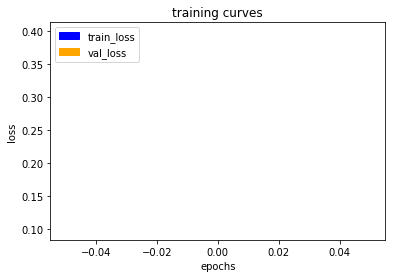

144/144 [==============================] - 224s - loss: 0.3978 - val_loss: 0.0984
Epoch 2/12
143/144 [============================>.] - ETA: 1s - loss: 0.0405

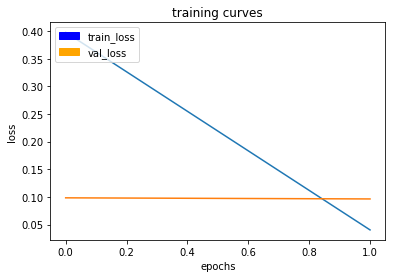

144/144 [==============================] - 222s - loss: 0.0404 - val_loss: 0.0964
Epoch 3/12
143/144 [============================>.] - ETA: 1s - loss: 0.0290

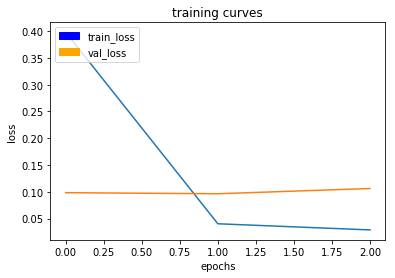

144/144 [==============================] - 223s - loss: 0.0289 - val_loss: 0.1062
Epoch 4/12
143/144 [============================>.] - ETA: 1s - loss: 0.0243

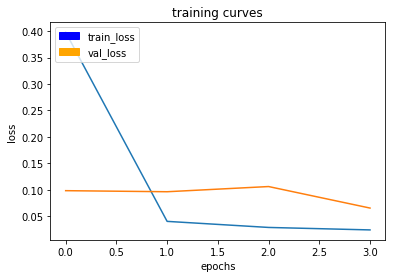

144/144 [==============================] - 224s - loss: 0.0242 - val_loss: 0.0655
Epoch 5/12
143/144 [============================>.] - ETA: 1s - loss: 0.0217

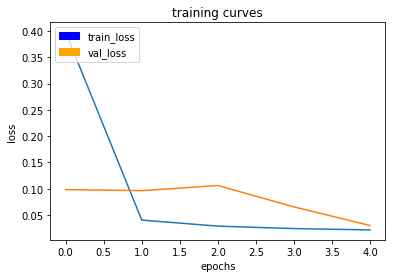

144/144 [==============================] - 223s - loss: 0.0217 - val_loss: 0.0301
Epoch 6/12
143/144 [============================>.] - ETA: 1s - loss: 0.0192

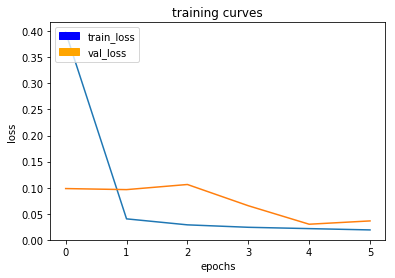

144/144 [==============================] - 222s - loss: 0.0192 - val_loss: 0.0364
Epoch 7/12
143/144 [============================>.] - ETA: 1s - loss: 0.0193

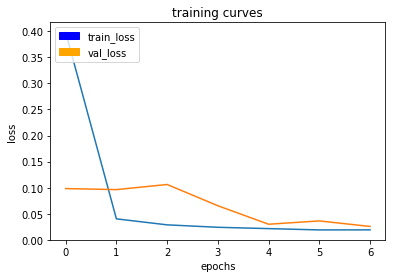

144/144 [==============================] - 222s - loss: 0.0193 - val_loss: 0.0259
Epoch 8/12
143/144 [============================>.] - ETA: 1s - loss: 0.0177

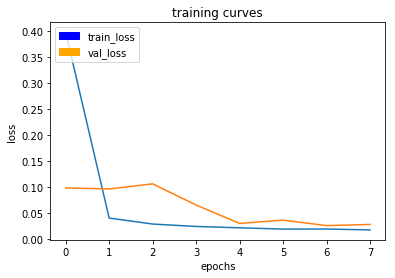

144/144 [==============================] - 221s - loss: 0.0177 - val_loss: 0.0281
Epoch 9/12
143/144 [============================>.] - ETA: 1s - loss: 0.0157

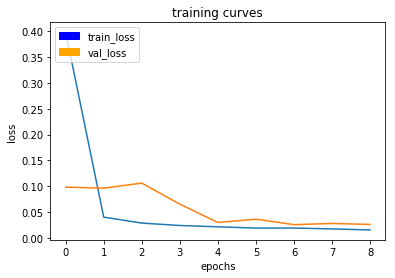

144/144 [==============================] - 221s - loss: 0.0157 - val_loss: 0.0263
Epoch 10/12
143/144 [============================>.] - ETA: 1s - loss: 0.0175

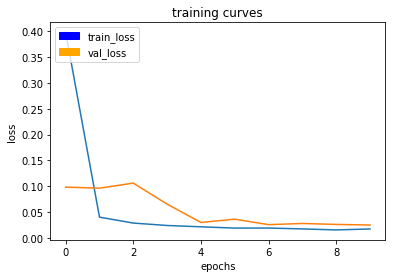

144/144 [==============================] - 221s - loss: 0.0175 - val_loss: 0.0251
Epoch 11/12
143/144 [============================>.] - ETA: 1s - loss: 0.0158

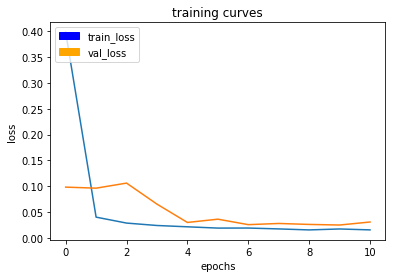

144/144 [==============================] - 222s - loss: 0.0157 - val_loss: 0.0310
Epoch 12/12
143/144 [============================>.] - ETA: 1s - loss: 0.0146

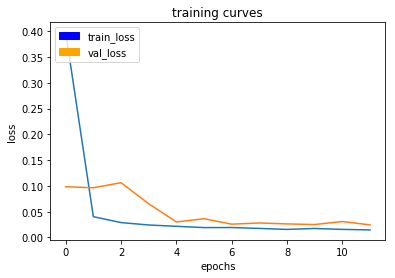

144/144 [==============================] - 221s - loss: 0.0147 - val_loss: 0.0244


In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
# tensorboard_cb = TensorBoard(log_dir=os.path.join('..','data','tensorboard_logs'), histogram_freq=1)
# callbacks = [logger_cb, tensorboard_cb]
callbacks = [logger_cb]


model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks = callbacks,
                    workers = workers)

In [53]:
# Save your trained model weights
weight_file_name = 'model_weights_{}'.format(time.strftime('%D_%T').replace('/','_').replace(':','_')) 
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [55]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights_04_30_18_16_05_41'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [56]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


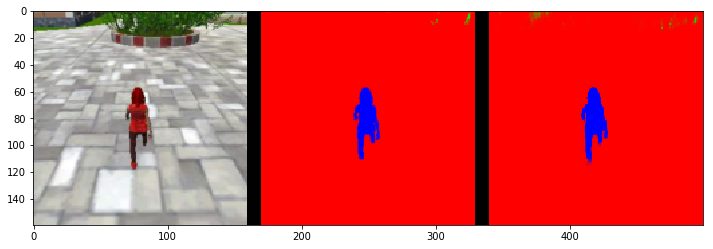

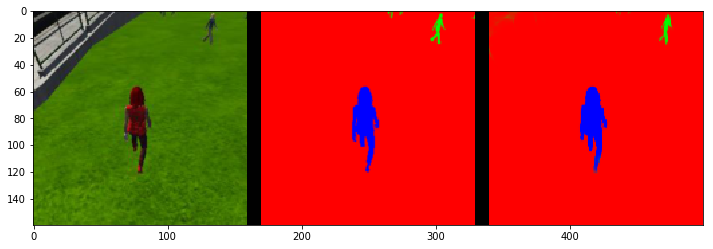

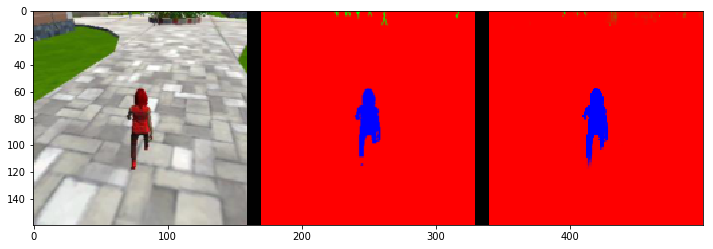

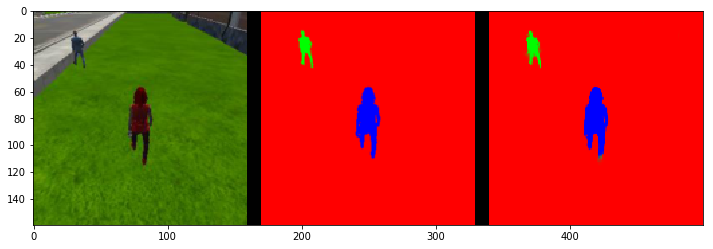

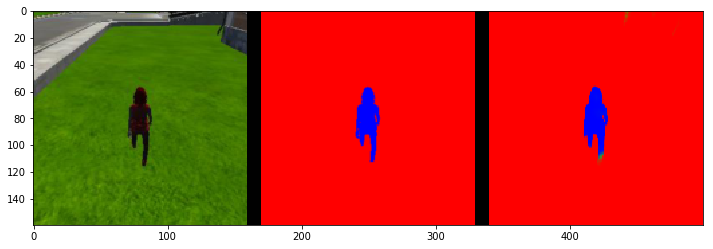

In [57]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


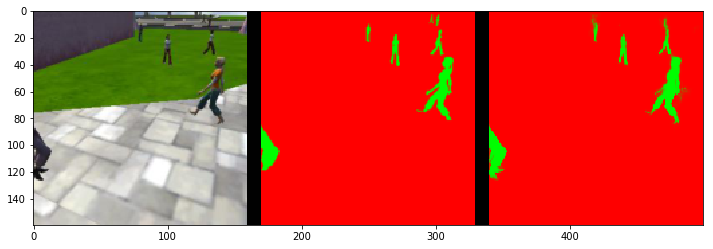

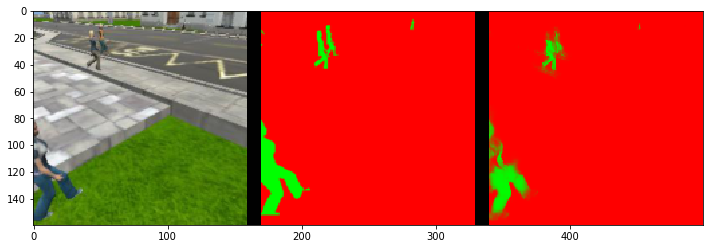

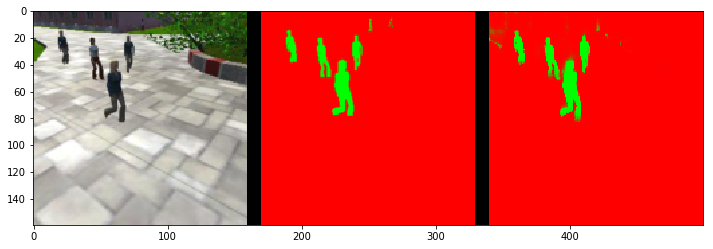

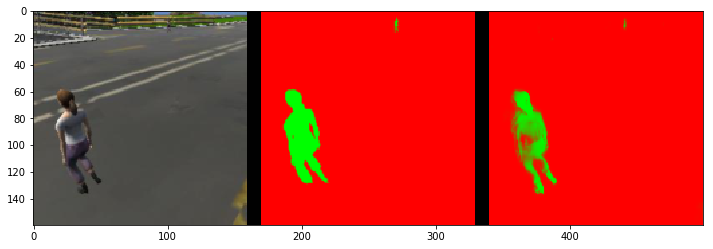

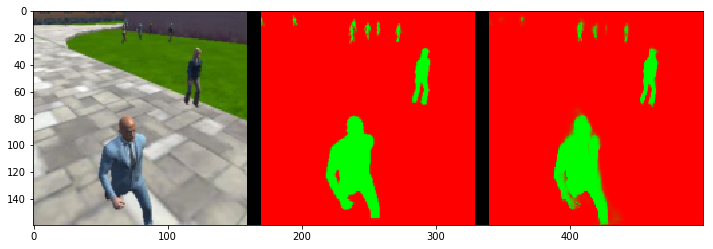

In [66]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


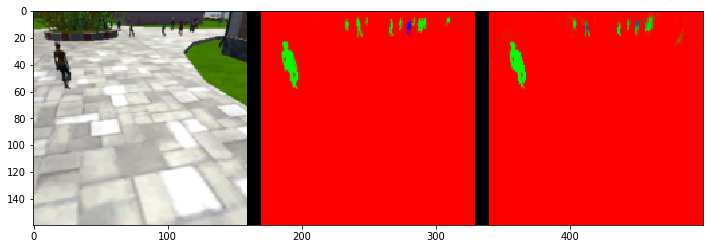

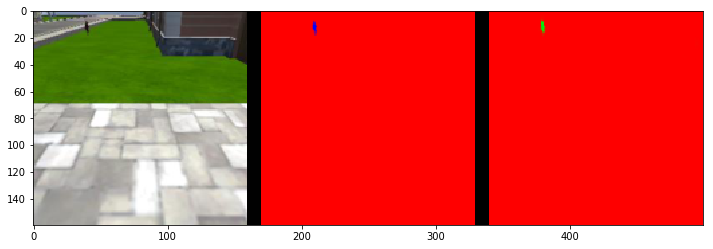

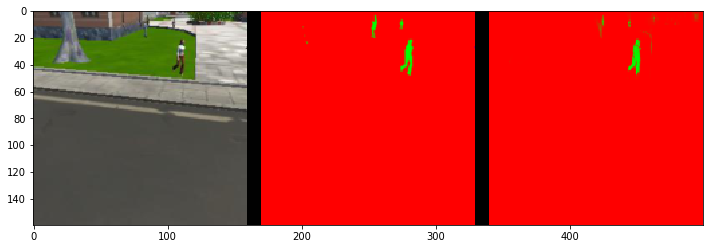

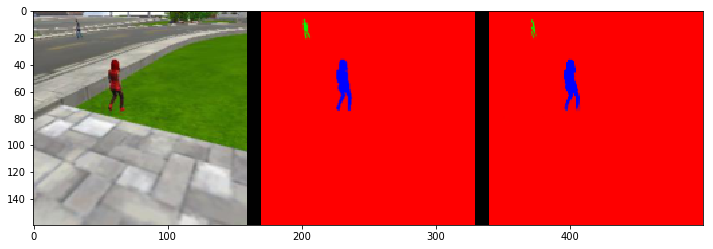

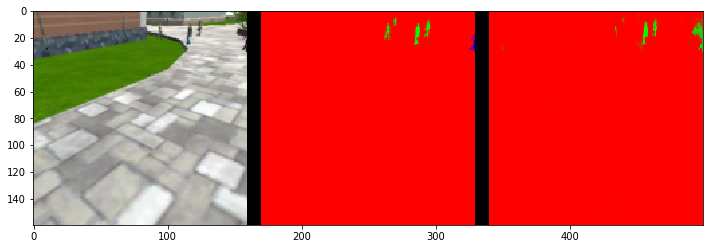

In [68]:
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [69]:
# Scores for while the quad is following behind the target
print("\nScores for while the quad is following behind the target:")
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

# Scores for images while the quad is on patrol and the target is not visible
print("\nScores for while the quad is on patrol and the target is not visible:")
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

# This score measures how well the neural network can detect the target from far away
print("\nThis score measures how well the neural network can detect the target from far away:")
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print("\nweight: {}".format(weight))

# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print("\nfinal_IoU: {}".format(final_IoU))

# And the final grade score is 
final_score = final_IoU * weight
print("\nfinal_score: {}".format(final_score))


Scores for while the quad is following behind the target:


/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/paperspace/anaconda3/envs/ml/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9951238947544851
average intersection over union for other people is 0.359012553689975
average intersection over union for the hero is 0.8968369439393451
number true positives: 539, number false positives: 0, number false negatives: 0

Scores for while the quad is on patrol and the target is not visible:
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9882957603877837
average intersection over union for other people is 0.7774235931534899
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 17, number false negatives: 0

This score measures how well the neural network can detect the target from far away:
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9967083059

    `
    def separable_conv2d_batchnorm(input_layer, filters, strides=1, kernel_size=3):
        output_layer = SeparableConv2DKeras(filters=filters, kernel_size=kernel_size, strides=strides,
                                 padding='same', activation='relu')(input_layer)

        output_layer = layers.BatchNormalization()(output_layer)
        return output_layer


    def conv2d_batchnorm(input_layer, filters, kernel_size=5, strides=1):
        output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                          padding='same', activation='relu')(input_layer)

        output_layer = layers.BatchNormalization()(output_layer) 
        return output_layer



    def separable_conv2d_batchnorm_dropout(input_layer, filters, strides=1, kernel_size=3, rate=0.3):
        output_layer = layers.Dropout(rate = rate)(input_layer)
        output_layer = SeparableConv2DKeras(filters=filters, kernel_size=kernel_size, strides=strides,
                                 padding='same', activation='relu')(input_layer)

        output_layer = layers.BatchNormalization()(output_layer)
        return output_layer


    def conv2d_batchnorm_dropout(input_layer, filters, kernel_size=3, strides=1, rate=0.3):
        output_layer = layers.Dropout(rate=rate)(input_layer)
        output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                          padding='same', activation='relu')(output_layer)
        output_layer = layers.BatchNormalization()(output_layer) 
        return output_layer


    def max_pool(input_layer, pool_size=2, strides=2):
        output_layer = layers.MaxPool2D(pool_size = pool_size, strides=strides, padding='same')(input_layer)
        return output_layer
    
    
    def encoder_block(input_layer, filters, strides):
        # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
        output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
        return output_layer

    def pooling_encoder_block(input_layer, filters, conv_strides, pool_size, pool_strides):
        # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
        output_layer = separable_conv2d_batchnorm(input_layer, filters, conv_strides)
        output_layer = max_pool(output_layer, pool_size, pool_strides)
        return output_layer


    def sensory_interface_block(input_layer, filters, strides, kernel_size=7):
        output_layer = separable_conv2d_batchnorm(input_layer, filters, strides, kernel_size=kernel_size)
        return output_layer


    def dropout_pooling_block(input_layer, filters, conv_strides, pool_size, pool_strides, kernel_size, rate):
        output_layer = separable_conv2d_batchnorm_dropout(input_layer, filters, conv_strides, 
                                                          kernel_size=kernel_size, rate=rate)
        output_layer = max_pool(output_layer, pool_size, pool_strides)
        return output_layer
        
        
    def decoder_block(small_ip_layer, large_ip_layer, filters):

        # TODO Upsample the small input layer using the bilinear_upsample() function.
        upsampled = bilinear_upsample(small_ip_layer)

        # TODO Concatenate the upsampled and large input layers using layers.concatenate
        output_layer = layers.concatenate([upsampled, large_ip_layer])

        # TODO Add some number of separable convolution layers
        output_layer = separable_conv2d_batchnorm(output_layer, filters)

        return output_layer
    
    
    def fcn_dropout_model_0(inputs, num_classes):
        # TODO Add Encoder Blocks. 
        # Remember that with each encoder layer, the depth of your model (the number of filters) increases
        interface = sensory_interface_block(inputs, 92, 1, kernel_size=5)

        encode_1 = dropout_pooling_block(interface, filters=64, conv_strides=1, pool_size=2, 
                                         pool_strides=2, kernel_size=5, rate=0.4)

        encode_2 = dropout_pooling_block(encode_1, filters=128, conv_strides=1, pool_size=2, 
                                         pool_strides=2, kernel_size=3, rate=0.3)

        encode_3 = dropout_pooling_block(encode_2, filters=128, conv_strides=1, pool_size=2, 
                                         pool_strides=2, kernel_size=3, rate=0.3)

        # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
        core_map = conv2d_batchnorm_dropout(encode_3, filters=256, kernel_size=1, strides=1, rate=0.3)

        # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
        decode_1 = decoder_block(core_map, encode_2, 128)
        decode_2 = decoder_block(decode_1, encode_1, 92)
        decode_3 = decoder_block(decode_2, interface, 64)

        # The function returns the output layer of your model.
        # "x" is the final layer obtained from the last decoder_block()
        x = decode_3
        return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)`



Hyperparameters set Sat Apr 28 21:29:47 2018: learning_rate = 0.002, batch_size = 42, num_epochs = 12, steps_per_epoch = 140, validation_steps = 70, workers = 4;

Scores for while the quad is following behind the target:
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9921130859646468
average intersection over union for other people is 0.3352661926542504
average intersection over union for the hero is 0.8801180912407325
number true positives: 539, number false positives: 0, number false negatives: 0

Scores for while the quad is on patrol and the target is not visible:
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9845387539526556
average intersection over union for other people is 0.6943284157570913
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 159, number false negatives: 0

This score measures how well the neural network can detect the target from far away:
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9951879131523715
average intersection over union for other people is 0.4382300820395344
average intersection over union for the hero is 0.33125536311825626
number true positives: 195, number false positives: 5, number false negatives: 106

weight: 0.7310756972111554

final_IoU: 0.6056867271794943

final_score: 0.4428028463642917

In [71]:
learning_rate = 0.002
batch_size = 42
num_epochs = 12
steps_per_epoch = 144 # originally 200
validation_steps = 72 # originally 50
workers = 2 # originally 2

In [7]:
def modified_final_fcn_model(inputs, num_classes):
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases
    interface = sensory_interface_block(inputs, 64, 1, kernel_size=5)

    encode_1 = dropout_pooling_block(interface, filters=64, conv_strides=1, pool_size=2, 
                                     pool_strides=2, kernel_size=3, rate=0.5)

    encode_2 = dropout_pooling_block(encode_1, filters=96, conv_strides=1, pool_size=2, 
                                     pool_strides=2, kernel_size=3, rate=0.4)

    encode_3 = dropout_pooling_block(encode_2, filters=128, conv_strides=1, pool_size=2, 
                                     pool_strides=2, kernel_size=3, rate=0.4)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    core_map = conv2d_batchnorm_dropout(encode_3, filters=256, kernel_size=1, strides=1, rate=0.5)

    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decode_1 = decoder_block(core_map, encode_2, 128)
    decode_2 = decoder_block(decode_1, encode_1, 92)
    decode_3 = decoder_block(decode_2, interface, 64)

    # The function returns the output layer of your model.
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decode_3)

Params set Sun Apr 29 16:29:23 2018: learning_rate = 0.002, batch_size = 42, num_epochs = 12, steps_per_epoch = 144, validation_steps = 72, workers = 4;

Scores for while the quad is following behind the target:
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9951343990276144
average intersection over union for other people is 0.37037760080707083
average intersection over union for the hero is 0.9098100434149873
number true positives: 539, number false positives: 0, number false negatives: 0

Scores for while the quad is on patrol and the target is not visible:
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9836737090346791
average intersection over union for other people is 0.6645223552380941
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 73, number false negatives: 0

This score measures how well the neural network can detect the target from far away:
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9964426474929327
average intersection over union for other people is 0.45053639942519386
average intersection over union for the hero is 0.31042152131529777
number true positives: 171, number false positives: 3, number false negatives: 130

weight: 0.7751091703056768

final_IoU: 0.6101157823651425

final_score: 0.4729063378594445